In [1]:
import torch
import numpy as np
from orbit_gen import get_random_orbit, get_Rz, get_nadir_attitude, get_nadir_attitude_vectors
import rasterio
import matplotlib.pyplot as plt
from getMGRS import getMGRS
import os
import cv2

from PIL import Image
Image.MAX_IMAGE_PIXELS = None
torch.no_grad()

In [40]:
def get_eci_orbit(tf=None):
    if tf is not None:
        orbit_eci, tsamp, orbit_eci_q = get_random_orbit(tf=tf)
    else:
        orbit_eci, tsamp, orbit_eci_q = get_random_orbit()
    return orbit_eci, tsamp, orbit_eci_q

def get_orbit(tf=None):
    if tf is not None:
        orbit_eci, tsamp, orbit_eci_q = get_eci_orbit(tf)
    else:   
        orbit_eci, tsamp, orbit_eci_q = get_eci_orbit()
    # get time samples for Earth rotation
    Rzs = get_Rz(tsamp)
    # Get ECI position vector
    r_eci = orbit_eci[:, :3, np.newaxis]
    # Convert ECI position vector to ECEF
    r_ecef = np.matmul(Rzs, r_eci)

    # Stack position and attitude and convert to meters
    orbit_ecef = np.concatenate([r_ecef[:,:,0]*1000, orbit_eci[:,3:]], axis=1)
    return orbit_ecef, orbit_eci, tsamp, orbit_eci_q

In [41]:
#orbit_ecef, orbit_eci, tsamp, orbit_eci_q = get_orbit(10000)
orbit_ecef = np.load('test_orbit.npy')

In [42]:
class Vector3D:
    def __init__(self, x, y, z, device='cuda', dtype=torch.float64):
        self.x = torch.tensor(x, device=device, dtype=dtype)
        self.y = torch.tensor(y, device=device, dtype=dtype)
        self.z = torch.tensor(z, device=device, dtype=dtype)
    def get(self):
        return torch.stack([self.x, self.y, self.z], dim=0)

In [43]:
class SatelliteCamera:
    def __init__(self, fov, res, device='cuda', dtype=torch.float64):
        self.hfov = torch.tensor(fov, device=device, dtype=dtype)
        self.res = torch.tensor(res, device=device, dtype=torch.int32)
        self.vfov = self.hfov * (self.res[1] / self.res[0])
        self.focal_length = (self.res[0] / 2) / torch.tan(torch.deg2rad(self.hfov) / 2)
        self.device = device
        self.dtype = dtype
        self.K = self.intrinsic_matrix()
        self.pixel_locs = self.get_pixel_coords(res[1], res[0])
        self.grid = getMGRS()
        self.grid_bounds = torch.empty((0, 4), device=device, dtype=dtype)
        self.region_im_dict = {}
        self.region_id_map = {}
        for i, data in enumerate(self.grid.items()):
            key, val = data
            val_tens = torch.tensor(val, device=device, dtype=dtype).view(1,4)
            self.grid_bounds = torch.cat((self.grid_bounds,val_tens))
            self.region_id_map[i] = key
            self.region_im_dict[key] = None
        self.base_im = None
        self.get_base_im()
    
    def get_intrinsic_matrix(self):
        return self.K

    def intrinsic_matrix(self):
        return torch.tensor([[self.focal_length, 0, self.res[0]/2], [0, self.focal_length, self.res[1]/2], [0, 0, 1]], device=self.device, dtype=self.dtype)
    
    def get_camera_matrices(self, pos_vecs, dir_vecs, up_vecs, right_vecs):
        R_cw = torch.stack([-right_vecs.get(), -up_vecs.get(), dir_vecs.get()]).permute(2, 0, 1)
        pos_c = torch.matmul(-R_cw, pos_vecs.get().t().unsqueeze(-1))
        K_hom = torch.cat((self.K, torch.tensor([[0, 0, 0]], dtype=self.dtype, device=self.device)))
        K_hom = torch.cat((K_hom, torch.tensor([[0, 0, 0, 1]], dtype=self.dtype, device=self.device).t()), dim=1)
        E = torch.cat((R_cw, pos_c), dim=-1)
        hombatch = torch.zeros((E.shape[0], 1, 4), dtype=self.dtype, device=self.device)
        hombatch[:,:,-1] = 1
        E_hom = torch.cat((E, hombatch),dim=1)
        C_cw = torch.matmul(K_hom, E_hom)
        self.C_cw = C_cw
        return C_cw
    
    def get_pixel_coords(self, h, w):
        xs = torch.arange(0, w, device=self.device, dtype=self.dtype) + 0.5
        ys = torch.arange(0, h, device=self.device, dtype=self.dtype) + 0.5
        cartesian_prod = torch.cartesian_prod(xs, ys)
        pixel_locs = torch.cat((cartesian_prod, torch.ones((w*h, 1), device=self.device, dtype=self.dtype)), dim=1)
        return pixel_locs

    def get_corner_rays(self):
        C_cw_inv = torch.inverse(self.C_cw)
        corner_locs_hom = torch.tensor([[0, 0, 1, 0], [0, self.res[1], 1, 0], [self.res[0], self.res[1], 1, 0], [self.res[0], 0, 1, 0]], device=self.device, dtype=self.dtype)
        ray_vecs = torch.matmul(C_cw_inv, corner_locs_hom.t())
        ray_vecs = ray_vecs[:, :3, :] / torch.norm(ray_vecs[:, :3, :], dim=1).unsqueeze(1)
        return ray_vecs

    def get_ray_directions(self):
        C_cw_inv = torch.inverse(self.C_cw)
        pixel_locs_hom = torch.cat([self.pixel_locs, torch.zeros((self.pixel_locs.shape[0], 1), device=self.device, dtype=self.dtype)], dim=1)
        ray_vecs = torch.matmul(C_cw_inv, pixel_locs_hom.t())
        ray_vecs = ray_vecs[:, :3, :] / torch.norm(ray_vecs[:, :3, :], dim=1).unsqueeze(1)
        return ray_vecs
    
    def get_ray_directions_subset(self, num_rays = 1000):
        r = self.pixel_locs.shape[0] / num_rays
        C_cw_inv = torch.inverse(self.C_cw)
        pixel_locs_hom = torch.cat([self.pixel_locs, torch.zeros((self.pixel_locs.shape[0], 1), device=self.device, dtype=self.dtype)], dim=1)
        pixel_locs_hom_subset = pixel_locs_hom[::int(r)]
        ray_vecs = torch.matmul(C_cw_inv, pixel_locs_hom_subset.t())
        ray_vecs = ray_vecs[:, :3, :] / torch.norm(ray_vecs[:, :3, :], dim=1).unsqueeze(1)
        return ray_vecs
        
    def cast_rays(self, rays, pos_vecs):
        a = b = torch.tensor(6378137.0, device=self.device, dtype=self.dtype)
        c = torch.tensor(6356752.31424518, device=self.device, dtype=self.dtype)
        us = rays[:, 0, :]
        vs = rays[:, 1, :]
        ws = rays[:, 2, :]
        x = pos_vecs.x.unsqueeze(-1)
        y = pos_vecs.y.unsqueeze(-1)
        z = pos_vecs.z.unsqueeze(-1)
        value = -a**2*b**2*ws*z - a**2*c**2*vs*y - b**2*c**2*us*x
        radical = a**2*b**2*ws**2 + a**2*c**2*vs**2 - a**2*vs**2*z**2 + 2*a**2*vs*ws*y*z - a**2*ws**2*y**2 + b**2*c**2*us**2 - b**2*us**2*z**2 + 2*b**2*us*ws*x*z - b**2*ws**2*x**2 - c**2*us**2*y**2 + 2*c**2*us*vs*x*y - c**2*vs**2*x**2
        magnitude = a**2*b**2*ws**2 + a**2*c**2*vs**2 + b**2*c**2*us**2
        d = (value - a*b*c*torch.sqrt(radical)) / magnitude
        d[d < 0] = torch.nan

        xs_ecef = x + us*d
        ys_ecef = y + vs*d
        zs_ecef = z + ws*d

        return torch.stack([xs_ecef, ys_ecef, zs_ecef], dim=1)
    
    def ecef_to_llh(self, ecef_locs):
        a = torch.tensor(6378137.0, device=self.device, dtype=self.dtype)
        c = torch.tensor(6356752.31424518, device=self.device, dtype=self.dtype)
        f = (a - c) / a
        e_sq = f * (2 - f)
        eps = e_sq / (1.0 - e_sq)
        xs = ecef_locs[:, 0]
        ys = ecef_locs[:, 1]
        zs = ecef_locs[:, 2]
        p = torch.sqrt(xs**2 + ys**2)
        q = torch.atan2(zs * a, p * c)
        sin_q = torch.sin(q)
        cos_q = torch.cos(q)
        sin_q3 = sin_q**3
        cos_q3 = cos_q**3
        phi = torch.atan2(zs + eps * c * sin_q3, p - e_sq * a * cos_q3)
        lam = torch.atan2(ys, xs)
        # v = a / torch.sqrt(1.0 - e_sq * torch.sin(phi)**2)
        # h = p / torch.cos(phi) - v
        lat = torch.rad2deg(phi)
        lon = torch.rad2deg(lam)
        return lon, lat
    
    def get_base_im(self):
        if self.base_im is None:
            self.base_im = torch.tensor(np.asarray(Image.open('base_im.jpg')), device=self.device, dtype=torch.uint8) 
            base_transform = rasterio.transform.from_origin(-180, 90, 0.016666667, 0.016666667)
            self.base_transform = torch.tensor(~base_transform, device=self.device, dtype=self.dtype).view(3,3)

    def get_indexes_from_coords(self, lon, lat, transform):
        lonlat = torch.stack((lon, lat, torch.ones_like(lon)), dim=-1)
        self.indexes = torch.matmul(lonlat, transform.t())
        self.indexes = torch.round(self.indexes).int()
        return self.indexes
    
    def get_inbounds_indexes(self, im_h=None, im_w=None):
        if im_h is None:
            im_h = self.base_im.shape[0]
        if im_w is None:
            im_w = self.base_im.shape[1]
        self.inbounds = (self.indexes[:,:, 0] >= 0) & (self.indexes[:,:, 0] < im_w) & (self.indexes[:,:, 1] >= 0) & (self.indexes[:,:, 1] < im_h)
        return self.inbounds

    def get_regions(self, lons, lats):
        vector_lonlat = torch.cat((lons, lats), dim=0).t()
        check_bounds_lon = torch.logical_and(vector_lonlat[:, None, 0] > self.grid_bounds[None, :, 0],
                                              vector_lonlat[:, None, 0] < self.grid_bounds[None, :, 2])
        check_bounds_lat = torch.logical_and(vector_lonlat[:, None, 1] > self.grid_bounds[None, :, 1],
                                              vector_lonlat[:, None, 1] < self.grid_bounds[None, :, 3])
        check_bounds = torch.logical_and(check_bounds_lon, check_bounds_lat)
        region_id_int = torch.where(check_bounds)
        region_ids = [self.region_id_map[i.item()] for i in region_id_int[1]]
        region_ids = np.unique(region_ids)
        return region_ids
        
    def check_for_celestial_body(self, pos_vecs, num_rays = 1000):
        subset_rays = self.get_ray_directions_subset(num_rays=num_rays)
        subset_ecef_locs = self.cast_rays(subset_rays, pos_vecs)
        subset_lon, subset_lat = self.ecef_to_llh(subset_ecef_locs)
        regions = self.get_regions(subset_lon, subset_lat)

    def get_region_image(self, region):
        if self.region_im_dict[region] is None:
            if os.path.exists('region_ims/' + region):
                region_tif = np.random.choice(os.listdir('region_ims/' + region))
                regim_path = os.path.join('region_ims', region, region_tif)
                with rasterio.open(regim_path) as src:
                    trans = src.transform
                    trans_tensor = torch.tensor(~trans, device=self.device, dtype=self.dtype).view(3,3)
                    data = src.read()
                    regim = torch.tensor(data, device=self.device, dtype=torch.uint8).permute(1, 2, 0)
                    self.region_im_dict[region] = regim, trans_tensor
                return self.region_im_dict[region]
            else:
                return None, None
        else:
            return self.region_im_dict[region]

    def get_image(self, regions, pos_vecs):
        out_im = torch.zeros((self.res[1], self.res[0], 3), device=self.device, dtype=torch.uint8)
        pl = self.pixel_locs.int()
        ray_vecs = self.get_ray_directions()
        ecef_locs = self.cast_rays(ray_vecs, pos_vecs)
        lon, lat = self.ecef_to_llh(ecef_locs)
        # get base map
        indexes = self.get_indexes_from_coords(lon, lat, self.base_transform)
        inbounds = self.get_inbounds_indexes()
        in_indexes = indexes[inbounds, :]
        in_pl = pl[inbounds[0,:], :]
        out_im[in_pl[:, 1], in_pl[:, 0], :] = self.base_im[in_indexes[:, 1], self.res[0] - in_indexes[:, 0], :]
              
        # add imagery on top of base map
        for region in regions:
            regim, trans_tensor = self.get_region_image(region)
            if regim is None:
                continue
            regim_h, regim_w, _ = regim.shape    
            indexes = self.get_indexes_from_coords(lon, lat, trans_tensor)
            inbounds = self.get_inbounds_indexes(regim_h, regim_w)
            in_indexes = indexes[inbounds, :]
            in_pl = pl[inbounds[0,:], :]
            inbounds2 = regim[in_indexes[:, 1], in_indexes[:, 0], :].sum(axis=-1) > 1
            in_indexes = in_indexes[inbounds2]
            in_pl = in_pl[inbounds2]
            out_im[in_pl[:, 1], in_pl[:, 0], :] = regim[in_indexes[:, 1], in_indexes[:, 0], :]
        return out_im  

               

cam = SatelliteCamera(66, [4608, 2592])

In [44]:
device = 'cuda'
dtype = torch.double
batch_size = 1
rois = ['10S', '10T', '11R', '12R', '16T', '17R', '17T', '18S', 
        '32S', '32T', '33S', '33T', '52S', '53S', '54S', '54T']
num_rays = 1000
num_batches = 1

In [32]:
batch = 1600
start_idx = batch * batch_size
end_idx = min((batch + 1) * batch_size, orbit_ecef.shape[0])
pos_vecs = Vector3D(orbit_ecef[start_idx:end_idx, 0], orbit_ecef[start_idx:end_idx, 1], orbit_ecef[start_idx:end_idx, 2], device=device, dtype=dtype)
dir_vecs = Vector3D(orbit_ecef[start_idx:end_idx, 3], orbit_ecef[start_idx:end_idx, 4], orbit_ecef[start_idx:end_idx, 5], device=device, dtype=dtype)
up_vecs = Vector3D(orbit_ecef[start_idx:end_idx, 6], orbit_ecef[start_idx:end_idx, 7], orbit_ecef[start_idx:end_idx, 8], device=device, dtype=dtype)
right_vecs = Vector3D(orbit_ecef[start_idx:end_idx, 9], orbit_ecef[start_idx:end_idx, 10], orbit_ecef[start_idx:end_idx, 11], device=device, dtype=dtype)

print(dir_vecs.get(), up_vecs.get(), right_vecs.get(), pos_vecs.get(),pos_vecs.get().shape)

C_cw = cam.get_camera_matrices(pos_vecs, dir_vecs, up_vecs, right_vecs)
print(C_cw)

subset_rays = cam.get_ray_directions_subset(num_rays)
subset_ecef_locs = cam.cast_rays(subset_rays, pos_vecs)
subset_lon, subset_lat = cam.ecef_to_llh(subset_ecef_locs)
regions = cam.get_regions(subset_lon, subset_lat)
print(regions)

tensor([[-0.2962],
        [ 0.8189],
        [ 0.4915]], device='cuda:0', dtype=torch.float64) tensor([[ 0.1454],
        [-0.4700],
        [ 0.8706]], device='cuda:0', dtype=torch.float64) tensor([[-0.9440],
        [-0.3294],
        [-0.0202]], device='cuda:0', dtype=torch.float64) tensor([[ 1549393.8543],
        [-6328661.7379],
        [ 2255864.2669]], device='cuda:0', dtype=torch.float64) torch.Size([3, 1])
tensor([[[ 2.6666e+03,  3.0554e+03,  1.2041e+03,  1.2488e+10],
         [-8.9974e+02,  2.7288e+03, -2.4518e+03,  2.4194e+10],
         [-2.9624e-01,  8.1892e-01,  4.9155e-01,  4.5328e+06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0', dtype=torch.float64)
['15S' '16R' '16S' '17Q' '17R' '17S' '18Q' '18R' '18S' '19R' '19S']


In [33]:
#self = cam
out_im = torch.zeros((cam.res[1], cam.res[0], 3), device=cam.device, dtype=torch.uint8)
pl = cam.pixel_locs.int()
ray_vecs = cam.get_ray_directions()
ecef_locs = cam.cast_rays(ray_vecs, pos_vecs)
lon, lat = cam.ecef_to_llh(ecef_locs)
print(lon, lat)
indexes = cam.get_indexes_from_coords(lon, lat, cam.base_transform)
print(indexes)
indexes = cam.get_indexes_from_coords(lon, lat, cam.base_transform)
inbounds = cam.get_inbounds_indexes()
in_indexes = indexes[inbounds, :]
in_pl = pl[inbounds[0,:], :]
out_im[in_pl[:, 1], in_pl[:, 0], :] = cam.base_im[in_indexes[:, 1],  in_indexes[:, 0], :]


tensor([[     nan,      nan,      nan,  ..., -73.4006, -73.4013, -73.4021]],
       device='cuda:0', dtype=torch.float64) tensor([[    nan,     nan,     nan,  ..., 21.8331, 21.8315, 21.8300]],
       device='cuda:0', dtype=torch.float64)
tensor([[[-2147483648, -2147483648, -2147483648],
         [-2147483648, -2147483648, -2147483648],
         [-2147483648, -2147483648, -2147483648],
         ...,
         [       6396,        4090,           1],
         [       6396,        4090,           1],
         [       6396,        4090,           1]]], device='cuda:0',
       dtype=torch.int32)


In [38]:
out_im = cam.get_image(regions,pos_vecs)
# region = '17R'
# cam.region_im_dict[region] = None
# regim, trans_tensor = cam.get_region_image(region)
# print(regim, trans_tensor)
# # if regim is None:
# #     continue
# regim_h, regim_w, _ = regim.shape    
# indexes = cam.get_indexes_from_coords(lon, lat, trans_tensor)
# inbounds = cam.get_inbounds_indexes(regim_h, regim_w)
# in_indexes = indexes[inbounds, :]
# in_pl = pl[inbounds[0,:], :]
# inbounds2 = regim[in_indexes[:, 1], in_indexes[:, 0], :].sum(axis=-1) > 1
# in_indexes = in_indexes[inbounds2]
# in_pl = in_pl[inbounds2]
# out_im[in_pl[:, 1], in_pl[:, 0], :] = regim[in_indexes[:, 1], in_indexes[:, 0], :]

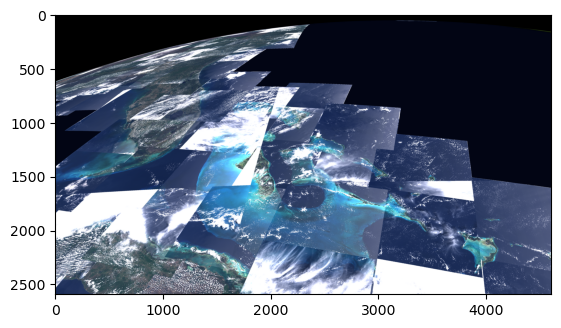

In [39]:
plt.imshow(out_im.cpu().numpy())

In [47]:
vid_w, vid_h = 1920, 1080
videowriter = cv2.VideoWriter('test.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 5, (vid_w, vid_h))
device = 'cuda'
dtype = torch.double
# pos_vecs = Vector3D(orbit_ecef[:, 0], orbit_ecef[:, 1], orbit_ecef[:, 2], device=device, dtype=dtype)
# dir_vecs = Vector3D(orbit_ecef[:, 3], orbit_ecef[:, 4], orbit_ecef[:, 5], device=device, dtype=dtype)
# up_vecs = Vector3D(orbit_ecef[:, 6], orbit_ecef[:, 7], orbit_ecef[:, 8], device=device, dtype=dtype)
# right_vecs = Vector3D(orbit_ecef[:, 9], orbit_ecef[:, 10], orbit_ecef[:, 11], device=device, dtype=dtype)
# C_cw = cam.get_camera_matrices(pos_vecs, dir_vecs, up_vecs, right_vecs)
batch_size = 1
num_batches = orbit_ecef.shape[0] // batch_size

rois = ['10S', '10T', '11R', '12R', '16T', '17R', '17T', '18S', 
        '32S', '32T', '33S', '33T', '52S', '53S', '54S', '54T']
num_rays = 1000

if num_batches * batch_size < orbit_ecef.shape[0]:
    num_batches += 1
#num_batches = 1
for batch in range(1400, 1800):#range(num_batches):
    #batch = 1600
    start_idx = batch * batch_size
    end_idx = min((batch + 1) * batch_size, orbit_ecef.shape[0])
    pos_vecs = Vector3D(orbit_ecef[start_idx:end_idx, 0], orbit_ecef[start_idx:end_idx, 1], orbit_ecef[start_idx:end_idx, 2], device=device, dtype=dtype)
    dir_vecs = Vector3D(orbit_ecef[start_idx:end_idx, 3], orbit_ecef[start_idx:end_idx, 4], orbit_ecef[start_idx:end_idx, 5], device=device, dtype=dtype)
    up_vecs = Vector3D(orbit_ecef[start_idx:end_idx, 6], orbit_ecef[start_idx:end_idx, 7], orbit_ecef[start_idx:end_idx, 8], device=device, dtype=dtype)
    right_vecs = Vector3D(orbit_ecef[start_idx:end_idx, 9], orbit_ecef[start_idx:end_idx, 10], orbit_ecef[start_idx:end_idx, 11], device=device, dtype=dtype)
    C_cw = cam.get_camera_matrices(pos_vecs, dir_vecs, up_vecs, right_vecs)
    # corner_rays = cam.get_corner_rays()
    # corner_ecef_locs = cam.cast_rays(corner_rays, pos_vecs)
    
    subset_rays = cam.get_ray_directions_subset(num_rays)
    subset_ecef_locs = cam.cast_rays(subset_rays, pos_vecs)
    if torch.isnan(subset_ecef_locs).sum() == subset_ecef_locs.numel():
        print('no earth')
        continue
    subset_lon, subset_lat = cam.ecef_to_llh(subset_ecef_locs)
    regions = cam.get_regions(subset_lon, subset_lat)
    if sum([1 for r in regions if r in rois]) == 0:
        print('no roi')
        continue
    print('found roi')
    #print(regions)
    # ray_vecs = cam.get_ray_directions()
    # #print(ray_vecs.shape)
    # #ray_vecs = ray_vecs[:, :3, :] / torch.norm(ray_vecs[:, :3, :], dim=1).unsqueeze(1)
    # ecef_locs = cam.cast_rays(ray_vecs, pos_vecs)
    # lon, lat = cam.ecef_to_llh(ecef_locs)
    # indexes = cam.get_indexes_from_coords(lon, lat, cam.base_transform)
    # inbounds = cam.get_inbounds_indexes()
    # new_im = torch.zeros((cam.res[1].int(), cam.res[0].int(), 3), device=device, dtype=torch.uint8)
    # in_indexes = indexes[inbounds, :]
    # in_pl = cam.pixel_locs[inbounds[0,:], :].int()
    # new_im[in_pl[:, 1], in_pl[:, 0], :] = cam.base_im[in_indexes[:, 1], in_indexes[:, 0], :]
    new_im = cam.get_image(regions, pos_vecs)
    new_im = cv2.cvtColor(new_im.cpu().numpy(), cv2.COLOR_RGB2BGR)
    new_im = cv2.resize(new_im, (vid_w, vid_h))
    videowriter.write(new_im)
    # cv2.imshow('frame2', new_im)
    # cv2.waitKey(1)
    #plt.imshow(new_im)
    #plt.show()
videowriter.release()

found roi
found roi
found roi
found roi
found roi
found roi
found roi
found roi
found roi
found roi
found roi
found roi
found roi
found roi
no roi
found roi
no roi
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth
no earth

In [ ]:
# cam.get_regions(corner_lon, corner_lat)
# vector_lonlat = torch.stack((corner_lon, corner_lat),dim=0).permute(1,0,2)
# vector_lonlat[:, 0, :] < cam.grid_bounds[None, :, 0]

# # check_bounds_lon = torch.logical_and(vector_lonlat[:, 0, :] > cam.grid_bounds[None, :, 0],
# #                                               vector_lonlat[:, None, 0] < cam.grid_bounds[None, :, 2])
# # check_bounds_lat = torch.logical_and(vector_lonlat[:, 0, 1] > cam.grid_bounds[None, :, 1],
# #                                         vector_lonlat[:, None, 1] < cam.grid_bounds[None, :, 3])
np.save('test_orbit.npy', orbit_ecef)


In [ ]:
check_bounds_lon = torch.logical_and(vector_lonlat[:, 0, :] > cam.grid_bounds[:, None, 0],
                                              vector_lonlat[:, 0, :] < cam.grid_bounds[:, None, 2])
check_bounds_lat = torch.logical_and(vector_lonlat[:, 1, :] > cam.grid_bounds[None, :, 1],
                                        vector_lonlat[:, 1, :] < cam.grid_bounds[None, :, 3])

RuntimeError: The size of tensor a (5) must match the size of tensor b (1197) at non-singleton dimension 0

In [ ]:
import time

corner_lon, corner_lat
vector_lonlat = torch.cat((corner_lon, corner_lat), dim=0).t()
vector_lonlat
start = time.time()
for vector in vector_lonlat:
    print(cam.get_region(vector[0], vector[1]))
print(time.time() - start)

AttributeError: 'SatelliteCamera' object has no attribute 'get_region'

In [ ]:
grid_bounds = torch.empty((0, 4), device=device, dtype=dtype)
region_id_map = {}
for i, data in enumerate(cam.grid.items()):
    key, val = data
    val_tens = torch.tensor(val, device=device, dtype=dtype).view(1,4)
    grid_bounds = torch.cat((grid_bounds,val_tens))
    region_id_map[i] = key
start = time.time()
check_bounds_lon = torch.logical_and(vector_lonlat[:, None, 0] > grid_bounds[None, :, 0], vector_lonlat[:, None, 0] < grid_bounds[None, :, 2])
check_bounds_lat = torch.logical_and(vector_lonlat[:, None, 1] > grid_bounds[None, :, 1], vector_lonlat[:, None, 1] < grid_bounds[None, :, 3])
check_bounds = torch.logical_and(check_bounds_lon, check_bounds_lat)
region_id_int = torch.where(check_bounds)
region_ids = [region_id_map[i.item()] for i in region_id_int[1]]
region_ids = np.unique(region_ids)

print(time.time() - start, region_ids)


0.005147218704223633 ['41K' '41L' '42J' '42K' '42L' '43J' '43K' '43L']


In [ ]:
torch.isnan(torch.tensor([torch.nan])).sum() == torch.tensor([torch.nan]).numel()
#torch.isnan(corner_ecef_locs).sum() == corner_ecef_locs.numel()
cam.grid_bounds

torch.Size([1197, 4])

In [ ]:
cam.pixel_locs
r = 0.05
pixel_locs_hom = torch.cat([cam.pixel_locs, torch.zeros((cam.pixel_locs.shape[0], 1), device=cam.device, dtype=cam.dtype)], dim=1)
pixel_locs_hom_subset = pixel_locs_hom[::int(1/r)]
pixel_locs_hom_subset.shape, pixel_locs_hom.shape
cam.pixel_locs.shape 

In [ ]:
print(indexes.shape, inbounds.shape, cam.pixel_locs.shape, in_indexes.shape)

In [ ]:
# index = 0
# C_cw_inv = torch.inverse(C_cw[index])
# pixel_locs_hom = torch.cat([cam.pixel_locs, torch.zeros((cam.pixel_locs.shape[0], 1), device=cam.device, dtype=cam.dtype)], dim=1)
# ray_vecs = torch.matmul(C_cw_inv, pixel_locs_hom.t())
# print(ray_vecs.shape)
# corner_rays = cam.get_corner_rays()
# rays = corner_rays
# ecef_locs = cam.cast_rays(rays, pos_vecs)
# lon, lat = cam.ecef_to_llh(ecef_locs)
# print(lon, lat)

# a = torch.tensor(6378137.0, device='cuda', dtype=torch.double)
# c = torch.tensor(6356752.31424518, device='cuda', dtype=torch.double)
# f = (a - c) / a
# e_sq = f * (2 - f)
# eps = e_sq / (1.0 - e_sq)
# xs = ecef_locs[:, 0]
# ys = ecef_locs[:, 1]
# zs = ecef_locs[:, 2]
# p = torch.sqrt(xs**2 + ys**2)
# q = torch.atan2(zs * a, p * c)
# sin_q = torch.sin(q)
# cos_q = torch.cos(q)
# sin_q3 = sin_q**3
# cos_q3 = cos_q**3
# phi = torch.atan2(zs + eps * c * sin_q3, p - e_sq * a * cos_q3)
# lam = torch.atan2(ys, xs)
# v = a / torch.sqrt(1.0 - e_sq * torch.sin(phi)**2)
# h = p / torch.cos(phi) - v
# lat = torch.rad2deg(phi)
# lon = torch.rad2deg(lam)
# print(lat, lon)

# print(corner_rays.shape)
# a = b = torch.tensor(6378137.0, device=device, dtype=dtype)
# c = torch.tensor(6356752.31424518, device=device, dtype=dtype)
# us = rays[:, 0, :]
# vs = rays[:, 1, :]
# ws = rays[:, 2, :]
# x = pos_vecs.x.unsqueeze(-1)
# y = pos_vecs.y.unsqueeze(-1)
# z = pos_vecs.z.unsqueeze(-1)
# print(x.shape, us.shape)

# value = -a**2*b**2*ws*z - a**2*c**2*vs*y - b**2*c**2*us*x
# radical = a**2*b**2*ws**2 + a**2*c**2*vs**2 - a**2*vs**2*z**2 + 2*a**2*vs*ws*y*z - a**2*ws**2*y**2 + b**2*c**2*us**2 - b**2*us**2*z**2 + 2*b**2*us*ws*x*z - b**2*ws**2*x**2 - c**2*us**2*y**2 + 2*c**2*us*vs*x*y - c**2*vs**2*x**2
# magnitude = a**2*b**2*ws**2 + a**2*c**2*vs**2 + b**2*c**2*us**2
# d = (value - a*b*c*torch.sqrt(radical)) / magnitude
# d[d < 0] = torch.nan

# xs_ecef = x + us*d
# ys_ecef = y + vs*d
# zs_ecef = z + ws*d

# torch.stack([xs_ecef, ys_ecef, zs_ecef], dim=1).shape

# C_cw_inv = torch.inverse(C_cw)
# print(C_cw.shape)

# pixel_locs = cam.pixel_locs
# pixel_locs_hom = torch.cat([pixel_locs, torch.zeros((pixel_locs.shape[0], 1), device=device, dtype=dtype)], dim=1)
# corner_locs_hom = torch.tensor([[0, 0, 1, 0], [0, 2592, 1, 0], [4608, 0, 1, 0], [4608, 2592, 1, 0]], device=device, dtype=dtype)
# print(corner_locs_hom)

# ray_vecs = torch.matmul(C_cw_inv, corner_locs_hom.t())
# print(ray_vecs[0])
# print(ray_vecs[:, :3, :].shape, torch.norm(ray_vecs[:, :3, :], dim=1).unsqueeze(1).shape)
# ray_vecs = ray_vecs[:, :3, :] / torch.norm(ray_vecs[:, :3, :], dim=1).unsqueeze(1)

In [ ]:
# R_cw = torch.stack([right_vecs.get().t(), -up_vecs.get().t(), dir_vecs.get().t()],dim=-1)
# print(R_cw.shape)
# pos_c = -torch.matmul(R_cw, pos_vecs.get().t().unsqueeze(-1))
# K = cam.K
# print(K)
# K_hom = torch.cat((K, torch.tensor([[0, 0, 0]], dtype=dtype, device=device)))
# K_hom = torch.cat((K_hom, torch.tensor([[0, 0, 0, 1]], dtype=dtype, device=device).t()), dim=1)
# print(K_hom)
# print(R_cw.shape, pos_c.shape)
# E = torch.cat((R_cw, pos_c), dim=-1)
# hombatch = torch.zeros((E.shape[0], 1, 4), dtype=dtype, device=device)
# hombatch[:,:,-1] = 1
# print(E.shape, hombatch.shape)
# E_hom = torch.cat((E, hombatch),dim=1)
# torch.matmul(K_hom, E_hom)


In [ ]:
# device = 'cuda'
# dtype = torch.float64
# pose = [549496.7936069818, -6128343.990241624, 3287548.8567509046,
#         -0.07876803246160267, 0.878472092968163, -0.4712561712468741,
#         -0.04208625123151773, 0.46937312065726633, 0.8819963838144332,
#         0.9960041890069568, 0.08930652540881052, -0.0]
# pos_vec = Vector3D(*pose[:3], device, dtype)
# dir_vec = Vector3D(*pose[3:6], device, dtype)
# up_vec = Vector3D(*pose[6:9], device, dtype)
# right_vec = Vector3D(*pose[9:12], device, dtype)